In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from nets import WeakRM

import matplotlib
import matplotlib.pyplot as plt

In [2]:
data_dir = ''
checkpoint_filepath = ''

int_u5 = np.load(data_dir + 'u5_ac4c_seq.npy', allow_pickle=True).astype(np.float32)
int_u3 = np.load(data_dir + 'u3_ac4c_seq.npy', allow_pickle=True).astype(np.float32)

instance_len = int_u3.shape[2]

int_u3.shape, instance_len

((2600, 56, 50, 4), 50)

In [3]:
model = WeakRM()
model(int_u3[0].reshape(1, -1, 50, 4))
model.load_weights(checkpoint_filepath)

In [4]:
u3_predictions = []
u3_weights = []
for i in np.arange(int_u3.shape[0]):
    y_pred, a_weights = model(int_u3[i].reshape(1, -1, 50, 4), training=False)
    u3_predictions.append(y_pred)
    u3_weights.append(a_weights)
u3_predictions = np.concatenate(u3_predictions, axis=0)
u3_weights = np.concatenate(u3_weights, axis=0)

u3_ind = [i[0] for i in sorted(enumerate(u3_predictions), key=lambda x:x[1],reverse=True) if
       u3_predictions[i[0]] > 0.5]

In [5]:
u5_predictions = []
u5_weights = []
for i in np.arange(int_u5.shape[0]):
    y_pred, a_weights = model(int_u5[i].reshape(1, -1, 50, 4), training=False)
    u5_predictions.append(y_pred)
    u5_weights.append(a_weights)
u5_predictions = np.concatenate(u5_predictions, axis=0)
u5_weights = np.concatenate(u5_weights, axis=0)

u5_ind = [i[0] for i in sorted(enumerate(u5_predictions), key=lambda x:x[1],reverse=True) if
       u5_predictions[i[0]] > 0.5]

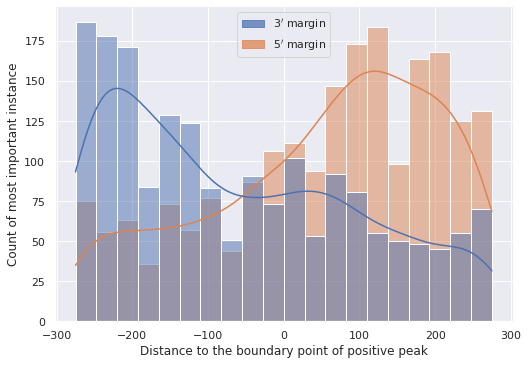

In [6]:
sns.set(style='darkgrid')

u3_best_weights = np.argmax(u3_weights[u3_ind], axis=1)
u5_best_weights = np.argmax(u5_weights[u5_ind], axis=1)

dist = np.concatenate([-300 + u3_best_weights*10 + 25, -300 + u5_best_weights*10 + 25])
group = np.concatenate([np.repeat('3prime', len(u3_best_weights)),
                        np.repeat('5prime', len(u5_best_weights))])
df = pd.DataFrame({'dist': dist, 'group': group})

g = sns.displot(df, x=dist, hue=group, bins=20, kde=True, aspect=1.5, legend=False)

g.set_xlabels('Distance to the boundary point of positive peak')
g.set_ylabels('Count of most important instance')

name_to_color = {
    '3$^\prime$ margin':   sns.color_palette()[0],
    '5$^\prime$ margin':   sns.color_palette()[1],
}

patches = [matplotlib.patches.Patch(color=v, label=k, alpha=0.75) for k,v in name_to_color.items()]
matplotlib.pyplot.legend(handles=patches)